# Variant calling and VCFs processing 

A few introductory points:

* In this notebook you will use both bash and python commands, the bash commands are marked with an "!" sign at the beginning of the line
*  You can run the code in each cell by clicking on the run cell sign, when the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing `+` in the Menu bar above. 



Import the necessary python libraries

In [2]:
import pandas
import allel
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

We need to make a link to where bcftools has been installed on our system. This is usually not necessary when you use bcftools installed on your computer.

In [2]:
%%bash
ln -sf /work/59896/scRNAseq/bin/bcftools ./bcftools

# 1.  **Variant calling**

We will use a tool named bcftools to find variants in the mapping files (.bam) relative to the reference genome, in this case, the file DNA_Contig1_2.fasta. The called variants will be stored in a VCF file (Variant Call Format). An SNP (single nucleotide polymorphism) is a type of variant, but here we will use the terms interchangeably.
<br>
When looking at an alignment file in IGV you should easily recognize the SNP positions. You can see that for the marked positions all the mapped reads have a mismatch compared to the reference. 

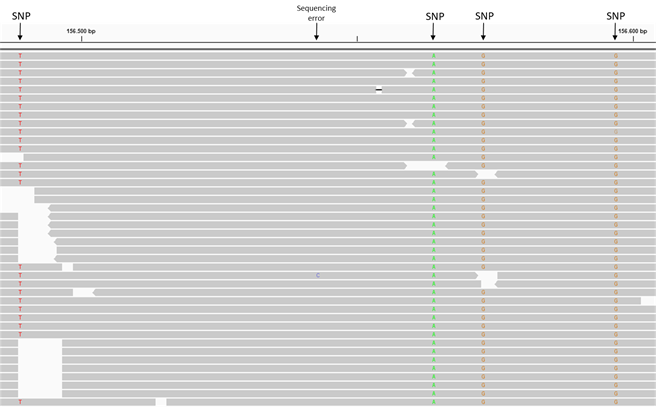

You will be calling two types of SNPs. First, we will find subgenome SNPs, differences between the two subgenomes of white clover (Contig1 and Contig2). Secondly, we will find SNPs that differenciate btween the sequenced white clover S10 (the reference genome) and Ti ecotype, using RNA-seq read mapping. 

First you will need to import 5 '.bam' files, which you generated on Galaxy, in the folder (CREATE FOLDER).

*  Hifi reads mapped to Contig1
*  Hifi reads mapped to Contig2
*  Hifi reads mapped to Contig 1 and 2
*  S10 RNAseq reads mapped to  Contig 1 and 2 (After merging the bam files)
*  Ti RNAseq reads mapped to  Contig 1 and 2 (After merging the bam files)

## 1.1 Call subgenome SNPs using the Hifi mapped data and the reference genome
This will generate 3 .vcf files stored in the folder. (CREATE FOLDER)

In [5]:
!mkdir VCF_Files

In [6]:
!./bcftools mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/Hifi_contig1.bam | ./bcftools call -mv -Ov -o VCF_Files/Hifi_Contig1.vcf
!./bcftools mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/Hifi_contig2.bam | ./bcftools call -mv -Ov -o VCF_Files/Hifi_Contig2.vcf
!./bcftools mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/Hifi_contig1_2.bam | ./bcftools call -mv -Ov -o VCF_Files/Hifi_Contig1_2.vcf

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


TASK

Inspect the VCF files using IGV, comparing them to the alignment BAM files.
Are there any problematic positions that may not represent subgenome SNPs? How can you use the
HiFi reads aligned to Contigs1&2 identify potential problems? Hint: Try scrolling to the ends of the
contigs.

**In case you have truble loading the bam files in IGV, they might need to be indexed.** NEED to CHECK

## 1.2 Call SNPs for the two RNA-seq Samples, S10 and Ti
This will result in another two vcf files.

In [4]:
!./bcftools mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/RNAseq_S10_Merged.bam | ./bcftools call -mv -Ov -o VCF_Files/RNAseq_S10_merged.vcf
!./bcftools mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/RNAseq_Ti_Merged.bam | ./bcftools call -mv -Ov -o VCF_Files/RNAseq_Ti_merged.vcf

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


TASK
* Inspect one of the VCFs and the corresponding alignment files in IGV.
* Are there any problematic positions that may not represent subgenome SNPs? How can you use the
HiFi reads aligned to Contigs1&2 identify potential problems? Hint: Try scrolling to the ends of the
contigs.

# 2. VCF files processing and filtering

Take a look at what one of the previously generate VCF files looks like by running the cell below.

A VCF file begins with the meta-information lines starting with '##' followed by one header line, starting with '#'. Next, there are the data lines, each describing a genetic variant for a certain position in the genome. Each data line contains multiple tab-delimited columns with information about the variant. There are 9 fixed columns, labelled “CHROM”, “POS”, “ID”, “REF”, “ALT”, “QUAL”, “FILTER”, “INFO” and “FORMAT”. Please read more about the information stored in each column: https://en.wikipedia.org/wiki/Variant_Call_Format .

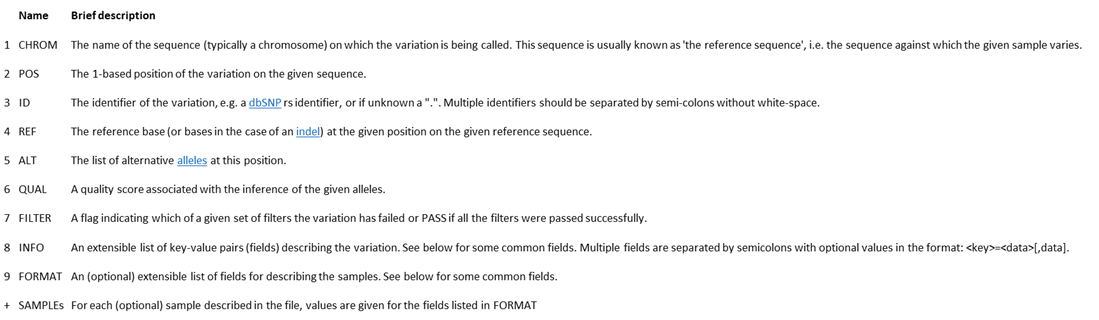

In [5]:
!cat RNAseq_S10_merged.vcf | head -50

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.15.1+htslib-1.15.1
##bcftoolsCommand=mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/RNAseq_S10_Merged.bam
##reference=file://../Data/Clover_Data/DNA_Contig1_2.fasta
##contig=<ID=1,length=1031631>
##contig=<ID=2,length=1057923>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,Type=Float,Descripti

Next, in order to generate some plots of the metrics stored in the VCF files, we will first import the VCF files in python using the scikit-allel package.
<br>
For now, we will import only the files with Hifi subgenome SNPs.


In [1]:
#Read the vcf file
Hifi_Contig1_vcf = allel.read_vcf('VCF_Files/Hifi_Contig1.vcf', fields='*')
Hifi_Contig2_vcf = allel.read_vcf('VCF_Files/Hifi_Contig2.vcf', fields='*')
Hifi_Contig1_2_vcf = allel.read_vcf('VCF_Files/Hifi_Contig1_2.vcf', fields='*')

NameError: name 'allel' is not defined

Let's check the number of variants in each vcf file. 

In [18]:
print("Number of SNPs in Hifi Contig 1 vcf file:", Hifi_Contig1_vcf['variants/POS'].size)
print("Number of SNPs in Hifi Contig 2 vcf file:", Hifi_Contig2_vcf['variants/POS'].size)
print("Number of SNPs in Hifi Contig 1 and 2 vcf file:", Hifi_Contig1_2_vcf['variants/POS'].size)

Number of SNPs in Hifi Contig 1 vcf file: 31981
Number of SNPs in Hifi Contig 2 vcf file: 30823
Number of SNPs in Hifi Contig 1 and 2 vcf file: 472


As an overview of the distribution of SNPs, we can plot the density of SNPs across the contigs.

First, we will define a function for this purpose. 

In [16]:
def plot_variant_density(variants, window_size, title=None):
    
    # setup windows 
    bins = np.arange(0, variants['variants/POS'][:].max(), window_size)
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(variants['variants/POS'][:], bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(11, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Contig position (bp)')
    ax.set_ylabel('SNP density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

Now we can plot the SNP density across the contigs in the three vcf files in bins of 5000 bp:

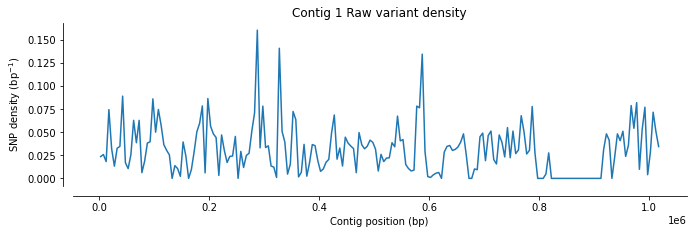

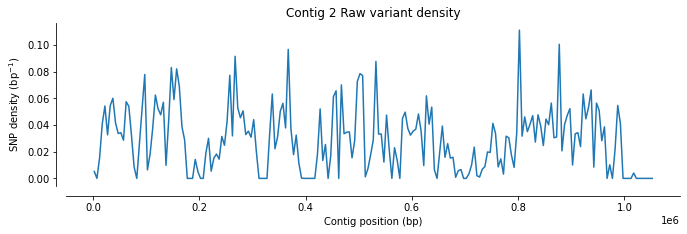

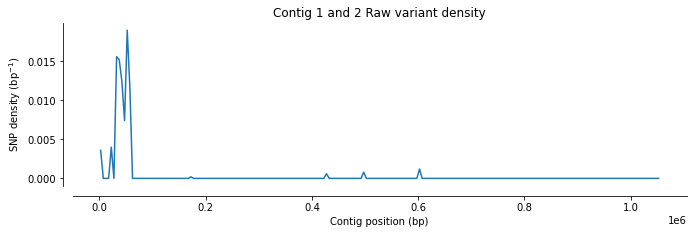

In [49]:
#Plot SNP density
plot_variant_density(Hifi_Contig1_vcf, window_size=5000, title='Contig 1 Raw variant density')
plot_variant_density(Hifi_Contig2_vcf, window_size=5000, title='Contig 2 Raw variant density')
plot_variant_density(Hifi_Contig1_2_vcf, window_size=5000, title='Contig 1 and 2 Raw variant density')

We can also plot some of the most relevant metrics from the VCF files, such as the read depth and the quality.
<br> 
First, we will define a function for plotting. 

In [18]:
def plot_variant_hist(variants, f, colour="mediumblue", bins=50):
    x = variants['variants/'+f][:]
    fig, ax = plt.subplots(figsize=(9, 4))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins, color = colour)
    ax.set_xlabel(f)
    ax.set_ylabel('No. SNPs')
    ax.set_title('Variant %s distribution' % f)

Now, we can plot the metrics for Hifi_Contig1_vcf. 
For example, here we are plotting the "DP" (Read depth),  "QUAL" (Quality score), and "MQ" (Mapping quality).
<br>
The x-axis represents the chosen metric, while the y-axix represents the number of SNPs.



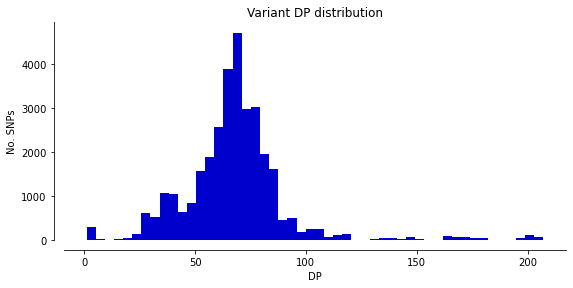

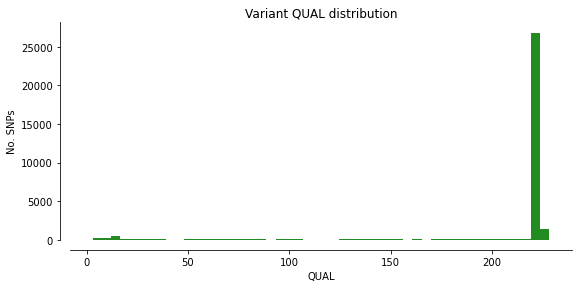

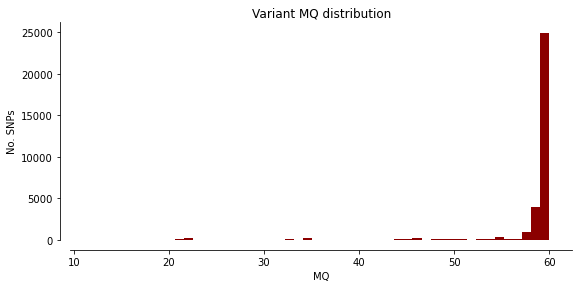

In [19]:
plot_variant_hist(Hifi_Contig1_vcf,'DP', "mediumblue")
plot_variant_hist(Hifi_Contig1_vcf, 'QUAL', "forestgreen")
plot_variant_hist(Hifi_Contig1_vcf, 'MQ', "darkred")

TASK
<br>
*In the two cells below generate the same plots as above using the VCF files for Contig 2 and Contig 1 and 2.*
<br>
*You will just need to copy the three command lines from the cell above and replace the name of the VCF files.*

In [ ]:
#Metrics for Contig 2

In [ ]:
#Metrics for Contig 1 and 2

As you can observe in the plots above, there are some positions with very low read depth and low quality. Those might represent false-positive variants. Thus, we will filter the VCF file in order to eliminate those positions.
<br>
For this purpose, we will use another function provided by bcftools, the filter function. We can pass thresholds for all the info metrics to this function using the "-i" flag. Below is just an example of the thresholds, you can change the values to suit your files.
<br>
Note that this command will generate a new filtered vcf file.


In [20]:
!./bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' Hifi_Contig1.vcf -O v > vcf_Contig1_filtered.vcf

In [21]:
!./bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' Hifi_Contig2.vcf -O v > vcf_Contig2_filtered.vcf

In [22]:
!./bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' Hifi_Contig1_2.vcf -O v > vcf_Contig1_2_filtered.vcf

Read the filtered VCF files in python and gnerated the same plots as above.

TASK

Compare the VCF files before and after filtering in IGV. 

Number of SNPs in Contig 1 vcf filtered file: 29195


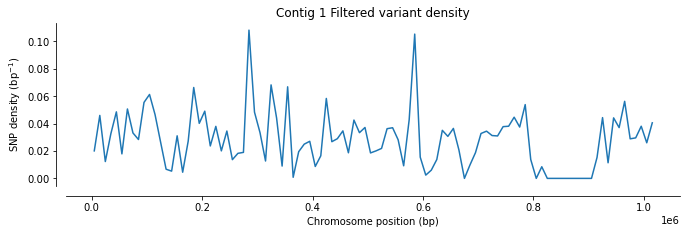

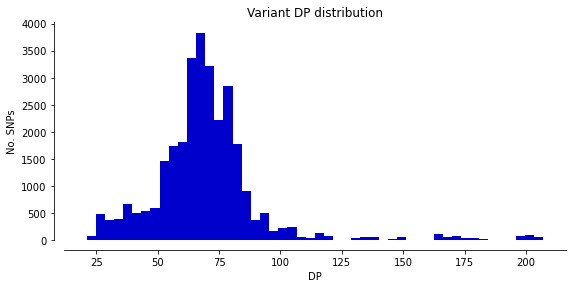

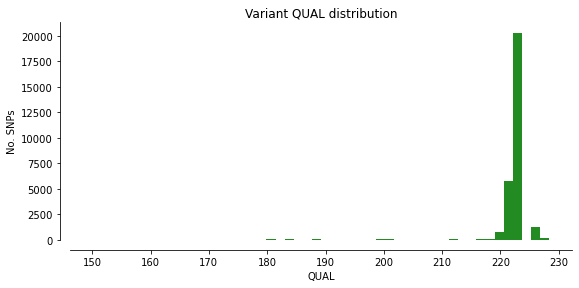

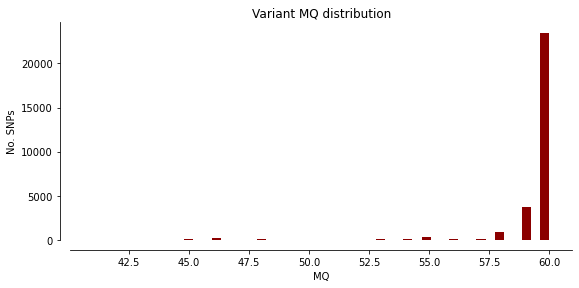

In [23]:
vcf_Contig1_filtered = allel.read_vcf('VCF_Files/vcf_Contig1_filtered.vcf', fields='*')

print("Number of SNPs in Contig 1 vcf filtered file:", vcf_Contig1_filtered['variants/POS'].size)

#Plot SNP density
plot_variant_density(vcf_Contig1_filtered, window_size=10000, title='Contig 1 Filtered variant density')
#Plot metrics
plot_variant_hist(vcf_Contig1_filtered,'DP',  "mediumblue")
plot_variant_hist(vcf_Contig1_filtered, 'QUAL',  "forestgreen")
plot_variant_hist(vcf_Contig1_filtered, 'MQ', "darkred")

TASK
<br>
*In the two cells below generate the same plots as above using the VCF files for Contig 2 and Contig 1 and 2.*
<br>
*You will just need to copy the three command lines from the cell above and replace the name of the VCF files.*

In [ ]:
#Figures Contig 2 

In [ ]:
#Figures Contig 1 and 2 

TASK 

*Repeat the quality check and filtering as described above for the two RNA-seq VCF files:*
<br>
You will need to fill the empty cells with the appropriate commands: 

Read the vcf files in Python:

In [24]:
vcf_S10_RNA = allel.read_vcf('VCF_Files/RNAseq_S10_merged.vcf', fields='*')
vcf_Ti_RNA = allel.read_vcf('VCF_Files/RNAseq_Ti_merged.vcf', fields='*')

Generate SNP density plots using the plot_variant_density() function:

Generate info histograms using the plot_variant_hist() function for the same fields:

Filter the vcf files using bcftools and your selected tresholds after inspecting the vcf files:

In [17]:
!./bcftools view -i 'add filter thresholds here' RNAseq_S10_merged.vcf -O v > VCF_Files/RNAseq_S10_merged_filtered.vcf
!./bcftools view -i 'add filter thresholds here' RNAseq_Ti_merged.vcf -O v > VCF_Files/RNAseq_Ti_merged_filtered.vcf

Read the filtered vcf in python:

In [18]:
vcf_S10_RNA = allel.read_vcf('VCF_Files/RNAseq_S10_merged_filtered.vcf', fields='*')
vcf_Ti_RNA = allel.read_vcf('VCF_Files/RNAseq_Ti_merged_filtered.vcf', fields='*')

Plot same histograms the filtered vcf files:

QUESTION:
* Is it relevant to filter for false positives in this case, and what parameters  would you look further into?

# 3. Genotypes counting

You are asked to fill in a table with the count for different genotypes in each of the 5 vcf files generated.
To make this task easier we can take advantage of the counting functions in the scikit-allel package.

First, we will define a function that automatically counts the number of heterozygous and homozygous positions in a give vcf file using scikit:

In [30]:
def position_count(vcf_file):
  pos_missing = allel.GenotypeChunkedArray(vcf_file['calldata/GT']).count_missing(axis=0)[:]
  pos_het = allel.GenotypeChunkedArray(vcf_file['calldata/GT']).count_het(axis=0)[:]
  pos_hom_ref = allel.GenotypeChunkedArray(vcf_file['calldata/GT']).count_hom_ref(axis=0)[:]
  pos_hom_alt = allel.GenotypeChunkedArray(vcf_file['calldata/GT']).count_hom_alt(axis=0)[:]
  print("Count missing positions:", int(pos_missing))
  print("Count heterozygous positions:", pos_het)
  print("Count homozygous reference positions:", pos_hom_ref)
  print("Count homozygous alternate positions:", pos_hom_alt)

You can then use the function with each of the 5 filtered vcf files to count the number of positions and fill the Excel table.

In [31]:
#Contig 1 filtered vcf
position_count(vcf_Contig1_filtered)

Count missing positions: 0
Count heterozygous positions: [27768]
Count homozygous reference positions: [0]
Count homozygous alternate positions: [1427]


In [ ]:
#Contig 2 filtered vcf
position_count()

In [ ]:
#Contig 1 and 2 filtered vcf
position_count()

In [ ]:
#RNAseq S10 filtered vcf
position_count()

In [ ]:
#RNAseq Ti filtered vcf
position_count()

# 4. Compare the VCF files with subgenome variants and the VCF files with S10/Tienshan genotype specific variants obtained from RNAseq mapping

In the second part of the table in the exercise manual you are asked to find overalpping position between the Contig 1 and Contig 2 Hifi vcf files and the Ti RNAseq vcf file. 

In order to ease this task we will first create merged vcf files for:


*   Hifi Contig 1 vcf + Ti RNAseq vcf
*   Hifi Contig 2 vcf + Ti RNAseq vcf

Once again we will use bcftools for this task. However, the "bcftools merge" function works only with compressed and indexed vcf files, so first we will do this. 


In [25]:
!./bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' VCF_Files/RNAseq_Ti_merged.vcf -O v > VCF_Files/RNAseq_Ti_merged_filtered.vcf #Just for test

In [26]:
!./bcftools view VCF_Files/vcf_Contig1_filtered.vcf -Oz -o VCF_Files/vcf_Contig1_filtered.vcf.gz
!./bcftools index VCF_Files/vcf_Contig1_filtered.vcf.gz -f -o VCF_Files/vcf_Contig1_filtered.vcf.gz.csi

!./bcftools view VCF_Files/vcf_Contig2_filtered.vcf -Oz -o VCF_Files/vcf_Contig2_filtered.vcf.gz
!./bcftools index VCF_Files/vcf_Contig2_filtered.vcf.gz -f -o VCF_Files/vcf_Contig2_filtered.vcf.gz.csi

!./bcftools view VCF_Files/RNAseq_Ti_merged_filtered.vcf -Oz -o VCF_Files/RNAseq_Ti_merged_filtered.vcf.gz
!./bcftools index VCF_Files/RNAseq_Ti_merged_filtered.vcf.gz -f -o VCF_Files/RNAseq_Ti_merged_filtered.vcf.gz.csi

Now we can merge Contig 1 vcf with the Ti RNA vcf and keep only positions that match between the two files. 

In [27]:
!./bcftools merge vcf_Contig1_filtered.vcf.gz RNAseq_Ti_merged_filtered.vcf.gz | ./bcftools filter -e 'GT="./."' > Contig1_Ti_merged.vcf

Merge Contig 2 vcf with the Ti RNA vcf and keep only positions that match between the two files

In [28]:
!./bcftools merge vcf_Contig2_filtered.vcf.gz RNAseq_Ti_merged_filtered.vcf.gz | ./bcftools filter -e 'GT="./."' > Contig2_Ti_merged.vcf

Take a look at the merged vcf file.
<br>
You can see that compared with the vcf files for just one sample, there is now a new column in the file, with the corresponding genotype:

In [26]:
!cat Contig1_Ti_merged.vcf | head -50

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.15.1+htslib-1.15.1
##bcftoolsCommand=mpileup --threads 1 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta ../Data/Clover_Data/Hifi_contig1.bam
##reference=file://../Data/Clover_Data/DNA_Contig1_2.fasta
##contig=<ID=1,length=1031631>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Read Po

In order to count the genotypes for the matching positions we can use once again "bcftools filter" command. Only that this time we will filter based on the genotype columns for the two samples (GT[0] and GT[1]). 

*   AR - heterozygous
*   AA - heterozygous alternate
<br>

For example, the filter 'GT[0]="AR" && GT[1]="AR"' will keep only position in which both samples have a heterozygous genotype.
We can then used the bash command "grep" to count all the lines in the vcf files that do not start with a "#", thus all the data lines. 

In [29]:
!./bcftools filter  -i 'GT[0]="AR" && GT[1]="AR"' Contig1_Ti_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AR" && GT[1]="AA"' Contig1_Ti_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AA" && GT[1]="AR"' Contig1_Ti_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AA" && GT[1]="AA"' Contig1_Ti_merged.vcf| grep -c -v "^#"

73
165
8
8


TASK
<br>
Use the same commands as above to count the positions marching the filters in the  Contig2_Ti_merged.vcf and fill the table form the exercise manual. 

THE END